# Gradient Boosting

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Leer la data

In [2]:
df = pd.read_csv('processed_data_listings.csv')
# Se ajusta el rango del precio entre 0 y 500.
df= df[(df['price'] > 0) & (df['price'] < 500)]
# Se eliminan columnas numericas sin relevancia
df = df.drop(columns = ['id', 'number_of_reviews_ltm'])
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Tower Hamlets,51.52874,-0.05396,Private room,55,3,1,74
1,Islington,51.56861,-0.11270,Private room,50,1,2,343
2,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,1,222
3,Islington,51.52478,-0.10484,Private room,180,4,5,236
4,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,1,180


## One hot encoding

In [3]:
df_hot_encoding = pd.get_dummies(df, columns=['neighbourhood', 'room_type'], drop_first=True)

## Transformacion logaritmica

Se utiliza para reducir la escala de valores y para manejar datos con sesgo o asimetría. Al aplicar la función logarítmica a los datos, se reduce la diferencia entre valores más grandes y más pequeños, lo que puede ayudar a estabilizar la varianza y mejorar la interpretación de las relaciones entre las variables.

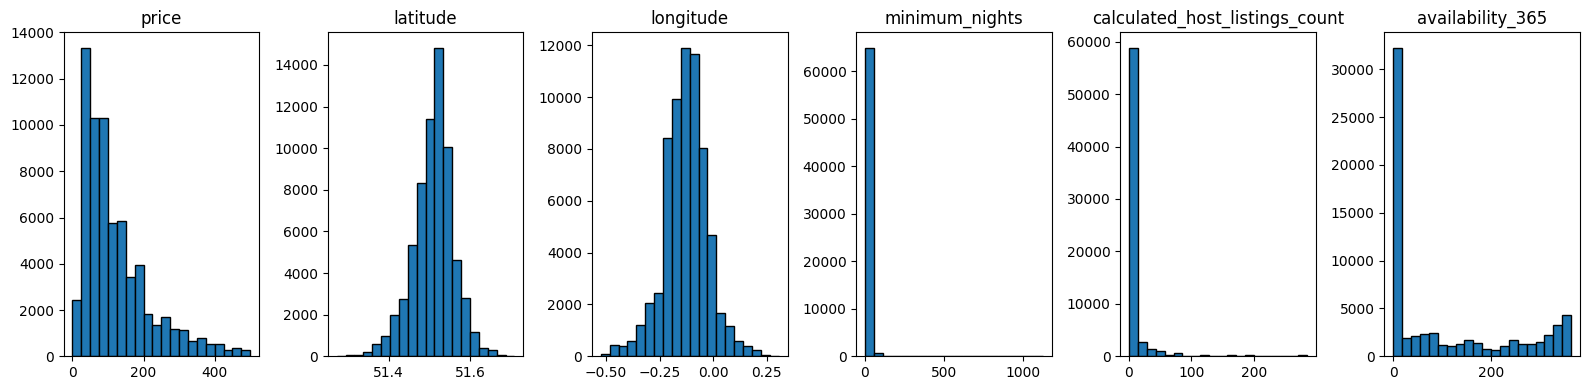

In [4]:
numeric_col = ['price', 'latitude', 'longitude','minimum_nights', 'calculated_host_listings_count','availability_365'] #, 'number_of_reviews_ltm'

# Crear una sola fila de subgráficos
fig, axes = plt.subplots(1, len(numeric_col), figsize=(16, 4))
# Generar histogramas para cada columna numérica
for i, col in enumerate(numeric_col):
    axes[i].hist(df_hot_encoding[col], bins=20, edgecolor='black')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [5]:
# Log transforming columns
numerical_columns = [i for i in numeric_col
                     if i not in ['availability_365', 'latitude', 'longitude']] # Removing items not to be transformed

for col in numerical_columns:
    df_hot_encoding[col] = df_hot_encoding[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df_hot_encoding[col] = np.log(df_hot_encoding[col])

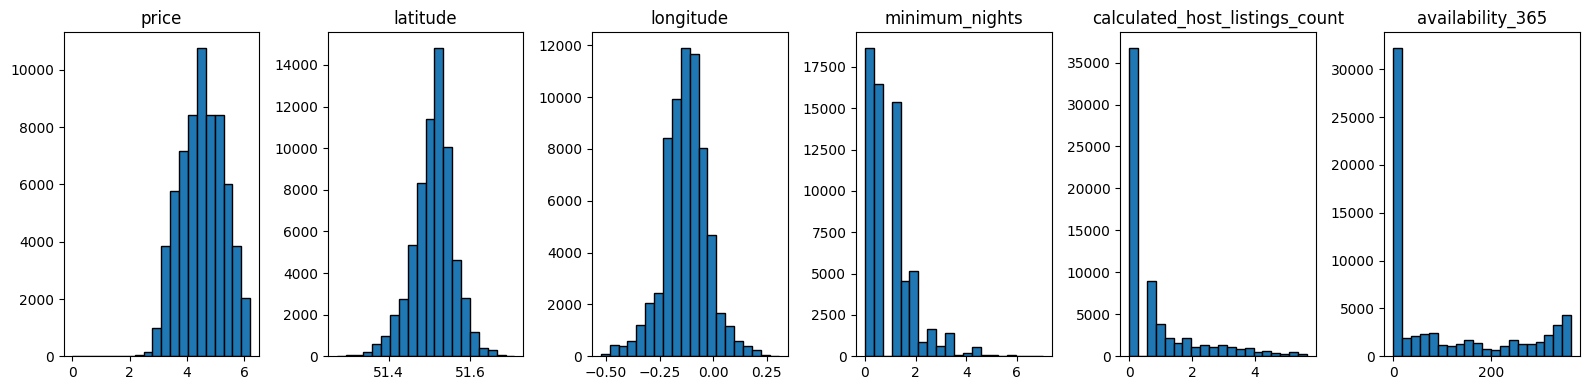

In [6]:
# Crear una sola fila de subgráficos
fig, axes = plt.subplots(1, len(numeric_col), figsize=(16, 4))
# Generar histogramas para cada columna numérica
for i, col in enumerate(numeric_col):
    axes[i].hist(df_hot_encoding[col], bins=20, edgecolor='black')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [7]:
df_hot_encoding.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,neighbourhood_Bromley,...,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,51.52874,-0.05396,4.007333,1.098612,0.000000,74,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,51.56861,-0.11270,3.912023,0.000000,0.693147,343,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,51.52851,-0.07426,4.499810,1.609438,0.000000,222,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,51.52478,-0.10484,5.192957,1.386294,1.609438,236,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,51.51464,-0.20004,5.693732,2.639057,0.000000,180,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prepared data to model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_hot_encoding.drop('price', axis=1)
y = df_hot_encoding.price
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

train_X, validation_X, train_y, validation_y = train_test_split(X, y, test_size=0.2, random_state = 42)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_y.shape))
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_y.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, y.shape))

Training set: Xt:(52724, 40) Yt:(52724,)
Validation set: Xv:(13181, 40) Yv:(13181,)
-
Full dataset: X:(65905, 40) Y:(65905,)


## Gradient Boosting

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score, mean_squared_error

***Grilla de hiperparametros***

In [ ]:
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

# Definir los hiperparámetros a probar en la búsqueda
param_grid = {
    'n_estimators': [400, 600, 800],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [6, 8, 10]
}

# Definir la métrica a optimizar (por ejemplo, el MAE)
scoring = make_scorer(mean_squared_error)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(gradient_boosting_model, param_grid, scoring=scoring, cv=5, verbose=2)
grid_search.fit(train_X, train_y)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba utilizando el mejor modelo
y_pred = best_model.predict(validation_X)

# Calcular el MAE en el conjunto de prueba
mae = mean_absolute_error(validation_y, y_pred)
r2 = r2_score(validation_y, y_pred)
rmse = np.sqrt(mean_squared_error(validation_y, y_pred))

# Imprimir los resultados
print("Mejores hiperparámetros encontrados:")
print(best_params)
print(f'MAE en el conjunto de prueba con los mejores hiperparámetros: {mae:.4f}')
print(f'R2 en el conjunto de prueba con los mejores hiperparámetros: {r2:.4f}')
print(f'RMSE en el conjunto de prueba con los mejores hiperparámetros: {rmse:.4f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=400; total time=  44.3s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=400; total time=  44.4s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=400; total time=  43.9s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=400; total time=  44.1s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=400; total time=  44.1s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=600; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=600; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=600; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=600; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=600; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=800; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=6, n_e

In [10]:
# Crear el modelo Gradient Boosting de Regresión
gradient_boosting_model = GradientBoostingRegressor(loss='squared_error',
                                  n_estimators=400,
                                  learning_rate=0.1,
                                  max_depth=8,
                                  random_state=42)

In [11]:
# Ajustar el modelo a los datos de entrenamiento
gradient_boosting_model.fit(train_X, train_y)

# Hacer predicciones en el conjunto de prueba
x_pred = gradient_boosting_model.predict(train_X)
y_pred = gradient_boosting_model.predict(validation_X)

In [12]:
# Metricas de evaluacion para el train
mae_x = mean_absolute_error(train_y, x_pred) # MAE (Mean Absolute Error)
r2_x = r2_score(train_y, x_pred) # R^2
rmse_x = np.sqrt(mean_squared_error(train_y, x_pred)) # RMSE (Root Mean Squared Error)

print(f'MAE: {mae_x:.4f}')
print(f'R^2: {r2_x:.4f}')
print(f'RMSE: {rmse_x:.4f}')

MAE: 0.2601
R^2: 0.7961
RMSE: 0.3367


In [13]:
# Metricas de evaluacion para el test
mae_y = mean_absolute_error(validation_y, y_pred) # MAE (Mean Absolute Error)
r2_y = r2_score(validation_y, y_pred) # R^2
rmse_y = np.sqrt(mean_squared_error(validation_y, y_pred)) # RMSE (Root Mean Squared Error)

print(f'MAE: {mae_y:.4f}')
print(f'R^2: {r2_y:.4f}')
print(f'RMSE: {rmse_y:.4f}')

MAE: 0.3327
R^2: 0.6635
RMSE: 0.4303


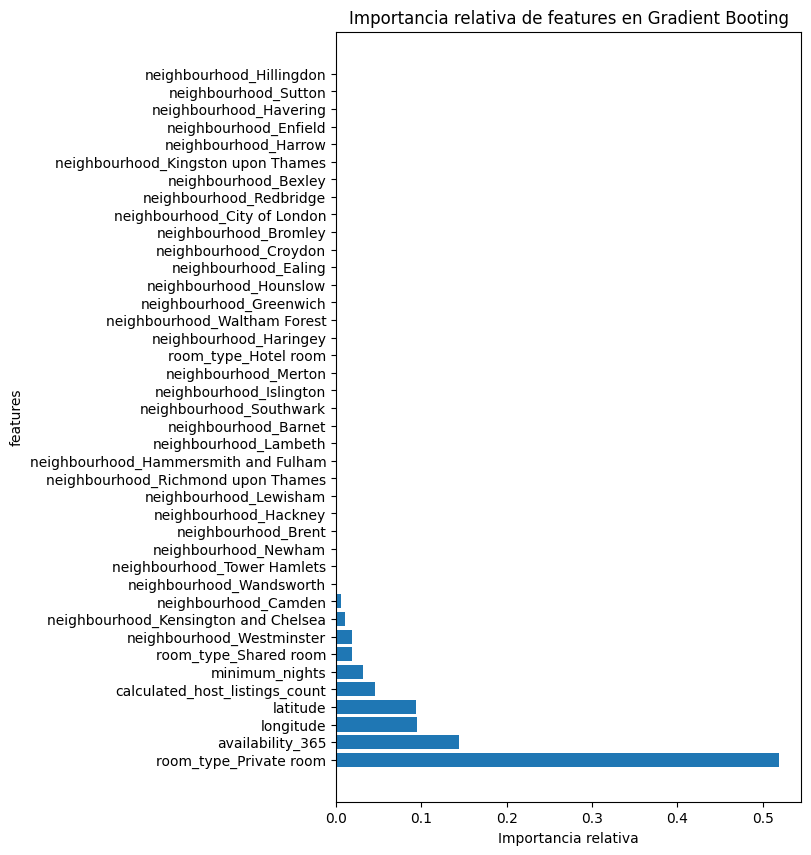

In [15]:
# Obtener la importancia de los features del modelo
feature_importance = gradient_boosting_model.feature_importances_

# Crear una lista de nombres de características (asumiendo que X_train es un DataFrame de pandas)
feature_names = train_X.columns.tolist()

# Obtener los índices que ordenan la importancia de mayor a menor
indices_sorted = np.argsort(feature_importance)[::-1]

# Ordenar las características y la importancia relativa según los índices ordenados
sorted_feature_names = [feature_names[i] for i in indices_sorted]
sorted_feature_importance = feature_importance[indices_sorted]

# Visualizar la importancia relativa de las características en un gráfico de barras ordenado
plt.figure(figsize=(6, 10))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Importancia relativa')
plt.ylabel('features')
plt.title('Importancia relativa de features en Gradient Booting')
plt.show()

In [14]:
# Importancia de características
importances = gradient_boosting_model.feature_importances_

feature_names = train_X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Ordena las características por importancia descendente
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Imprime la tabla con las importancias de características
feature_importances

,Feature,Importance
38,room_type_Private room,0.519089
4,availability_365,0.144368
1,longitude,0.094565
0,latitude,0.093338
3,calculated_host_listings_count,0.046147
2,minimum_nights,0.031803
39,room_type_Shared room,0.018701
36,neighbourhood_Westminster,0.018353
23,neighbourhood_Kensington and Chelsea,0.010134
9,neighbourhood_Camden,0.005471


In [39]:
validation_y_array = np.array(list(validation_y))
val_preds_hpm_reg_array = np.array(y_pred)
df_comparison_predictions = pd.DataFrame({'Actual': validation_y_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
df_comparison_predictions

,Actual,Predicted
0,4.867534,4.725395
1,4.442651,4.783711
2,4.828314,5.077659
3,4.007333,3.981752
4,5.860786,5.549668
...,...,...
13176,3.806662,3.990798
13177,4.605170,5.322616
13178,6.093570,4.726221
13179,3.806662,4.229670


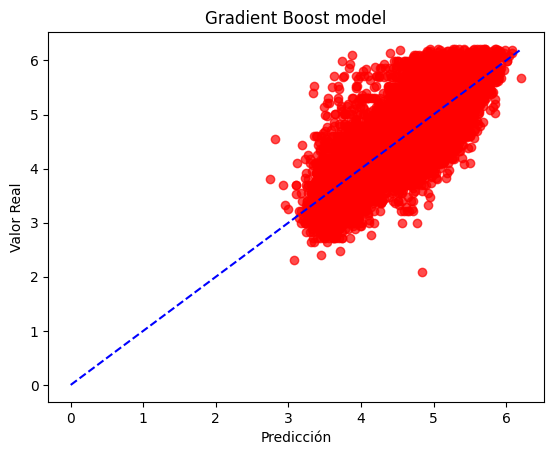

In [40]:
# Gráfica de la predicción
plt.scatter(y_pred, validation_y, alpha=0.7, color='r')
plt.plot(np.linspace(0, max(validation_y), 100), np.linspace(0, max(validation_y), 100), color='blue', linestyle='--')
plt.title('Gradient Boost model')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()